In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

import joblib

# 1. Preprocessing

In [6]:
space_titanic = pd.read_csv('train.csv')
test_titanic = pd.read_csv('test.csv')

space_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


***1.1 Null values***

Need to identify columns to drop and streamlining of data to reduce number of columns being analysed. 

Need to identify how many rows in the data set are missing more than a single variable and whether the proportion might warrant being dropped. 
Total values in dataset = 8693. 

The number of rows with missing values is: 2087


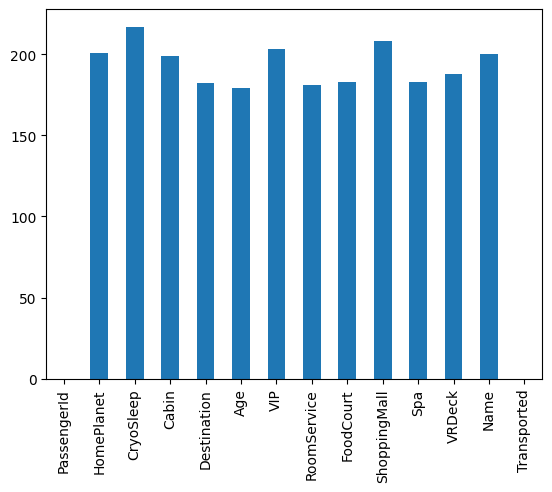

In [7]:
# Plot null values.
space_titanic.isnull().sum().plot.bar()

missing_rows = space_titanic.isnull().any(axis=1).sum()
print(f'The number of rows with missing values is: {missing_rows}')

In [8]:
train_space_titanic = space_titanic.copy()

# Replace null values for age. Replacing with median removes impact of outliers in age, that would impact the mean.
train_space_titanic['Age'] = train_space_titanic['Age'].fillna(space_titanic['Age'].median())

# Drop name from the dataset. 
train_space_titanic.drop(['Name'], axis=1, inplace=True)
train_space_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


In [9]:
# Look for how many rows are missing variables.
missing_values = train_space_titanic.isnull().any(axis=1).sum()
print(f'Total number of rows with missing values: {missing_values}')

threshold = 2

multi_missing_values = train_space_titanic.isnull().sum(axis=1)
rows_missing_variables = train_space_titanic[multi_missing_values >= threshold]
proportion = (missing_values / 8693) * 100
print(f'Proportion of rows missing data: {proportion:.2f}%')
print(f'Rows missing more than one variable: {len(rows_missing_variables)}')

Total number of rows with missing values: 1776
Proportion of rows missing data: 20.43%
Rows missing more than one variable: 161


***1.2 - Populating null values***

20.43% likely too high to drop whole rows. Will consider the frequency of variables such as 'HomePlanet' and 'Destination'. If there is one value that is in the majority, will edit null values to that.

Variables 'CryoSleep' and 'VIP' are binary. Will populate with mode. 

In [10]:
# Identify frequency of Home and destination planets.
HPfrequency_counts = space_titanic['HomePlanet'].value_counts(normalize=True)
DPfrequency_counts = space_titanic['Destination'].value_counts(normalize=True)
print(HPfrequency_counts)
print(DPfrequency_counts)

HomePlanet
Earth     0.541922
Europa    0.250942
Mars      0.207136
Name: proportion, dtype: float64
Destination
TRAPPIST-1e      0.694983
55 Cancri e      0.211491
PSO J318.5-22    0.093526
Name: proportion, dtype: float64


In [11]:
train_space_titanic['HomePlanet'] = train_space_titanic['HomePlanet'].fillna('Earth').replace('', 'Earth')
train_space_titanic['Destination'] = train_space_titanic['Destination'].fillna('TRAPPIST-1e').replace('', 'TRAPPIST-1e')

# Add NaN values in VIP and CryoSleep with Mode of the dataset for those variables. 
train_space_titanic['VIP'] = train_space_titanic['VIP'].replace('', np.nan).fillna(train_space_titanic['VIP'].mode()[0])
train_space_titanic['CryoSleep'] = train_space_titanic['CryoSleep'].replace('', np.nan).fillna(train_space_titanic['CryoSleep'].mode()[0])

C:\Users\Sam Working\AppData\Local\Temp\ipykernel_13672\4139482061.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_space_titanic['VIP'] = train_space_titanic['VIP'].replace('', np.nan).fillna(train_space_titanic['VIP'].mode()[0])
C:\Users\Sam Working\AppData\Local\Temp\ipykernel_13672\4139482061.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_space_titanic['CryoSleep'] = train_space_titanic['CryoSleep'].replace('', np.nan).fillna(train_space_titanic['CryoSleep'].mode()[0])


# 2.0 EDA

***2.1 - Analysis of Categorical variables***

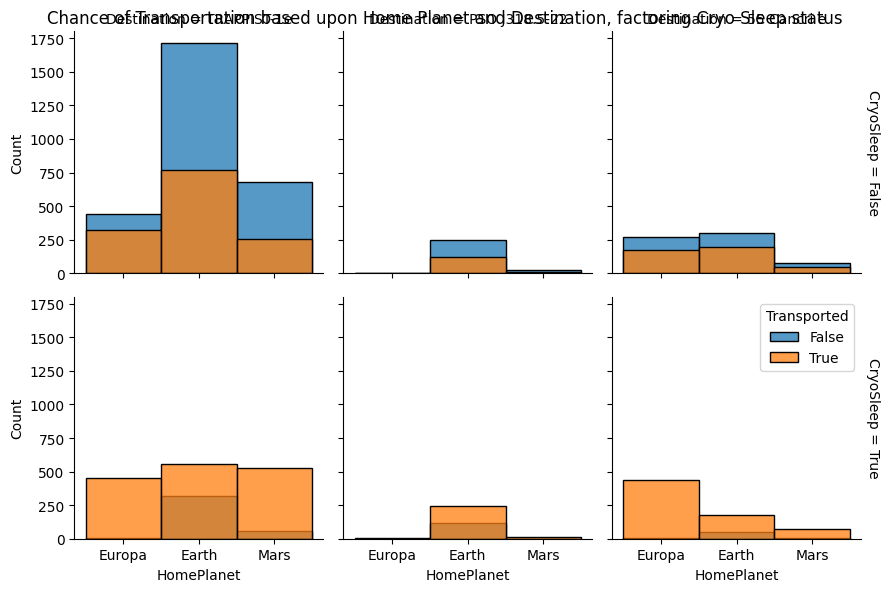

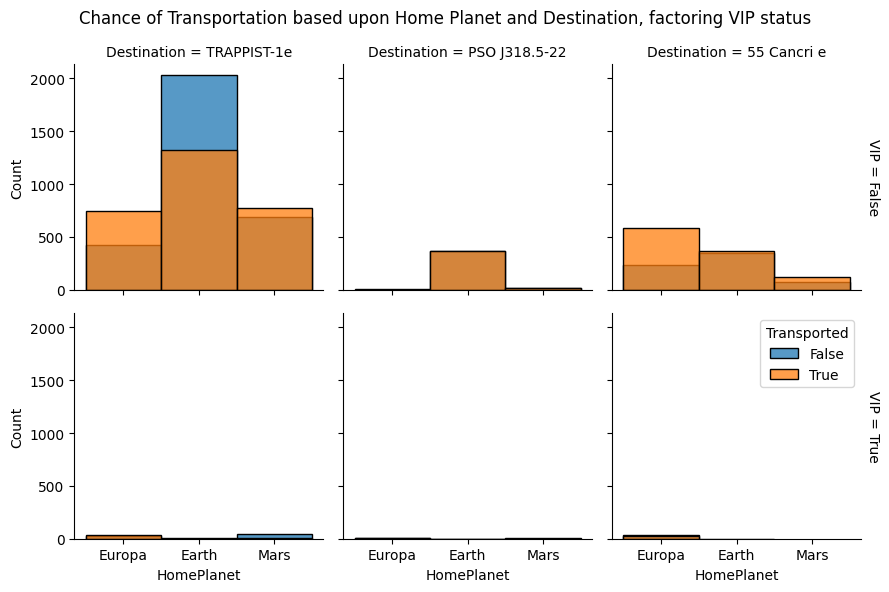

In [12]:
# Homeplanet vs destination planet - CryoSleep and VIP status
g = sns.FacetGrid(train_space_titanic, row='CryoSleep', col='Destination', margin_titles=True, hue='Transported')
g.map(sns.histplot, 'HomePlanet', bins=20)
g.set_axis_labels('HomePlanet', 'Count')
g.fig.suptitle('Chance of Transportation based upon Home Planet and Destination, factoring Cryo Sleep status')
plt.legend(title='Transported', loc='upper right')

f = sns.FacetGrid(train_space_titanic, row='VIP', col='Destination', margin_titles=True, hue='Transported')
f.map(sns.histplot, 'HomePlanet', bins=20)
f.set_axis_labels('HomePlanet', 'Count')
f.fig.suptitle('Chance of Transportation based upon Home Planet and Destination, factoring VIP status')
plt.legend(title='Transported', loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
# Understanding proportion of customers who has VIP status and in cryosleep.
VIPfrequency_counts = space_titanic['VIP'].value_counts(normalize=True)
cryofrequency_counts = space_titanic['CryoSleep'].value_counts(normalize=True)
print(VIPfrequency_counts)
print(cryofrequency_counts)

VIP
False    0.976561
True     0.023439
Name: proportion, dtype: float64
CryoSleep
False    0.641694
True     0.358306
Name: proportion, dtype: float64


Cryo sleep status appears to show a greater proportion of those in cryo sleep being transported than those who were not.
VIP status is a low proportion of the total subset after missing values have been changed to fit the mode. 

Transported:

VIP - 2 % , 
Cryo - 35%

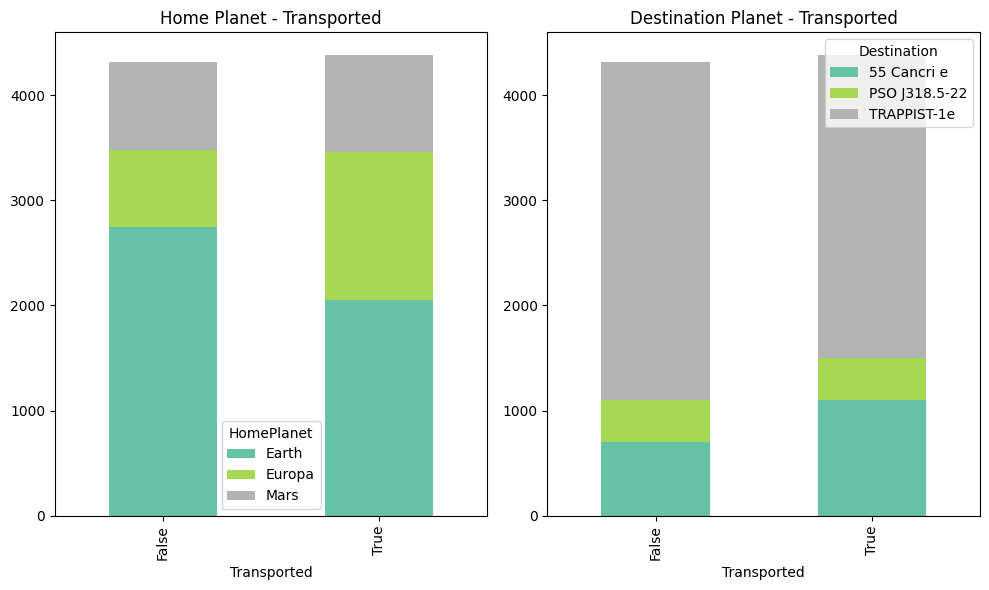

In [14]:
# Home vs. destination planet and transportation
counts_home = train_space_titanic.groupby(['Transported', 'HomePlanet']).size().unstack(fill_value=0)
counts_destination = train_space_titanic.groupby(['Transported', 'Destination']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Create a stacked bar chart
counts_home.plot(ax=axes[0], kind='bar', stacked=True, colormap='Set2')
axes[0].set_title('Home Planet - Transported')
counts_destination.plot(ax=axes[1], kind='bar', stacked=True, colormap='Set2')
axes[1].set_title('Destination Planet - Transported')

plt.tight_layout()
plt.show()

Equal proportion of passengers transported vs not transported. Need to consider proportion of each planet that is (not)transported. 

***2.2 - Analysis of Numerical variables***

In [ ]:
sns.pairplot(
    train_space_titanic[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Age']],
    kind='reg',
    diag_kind='kde',
    hue='Transported'
)

plt.show()

# 3.0 Feature engineering


Streamlining the number of variables used in the analysis of the problem. Will create a total value for the customer spend to provide one variable for analysis, rather than 5.  

Want to potentially look at whether the side of the ship that passengers were travelling is a variable that can be used to predict the chance of a passenger being transported. 
Will use one hot encoding the string value to enable numerical analysis to be conducted, knowing the the cabin variable code contains information on the side of the ship being traveled on. P = Port, S = Starboard

In [16]:
# Create total column for passenger spending onboard, to remove 5 standalone categories. 0 values represent no spend.
#train_space_titanic['Total_Spent'] = train_space_titanic[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
# Drop the 5 columns that have been used in calculation of Total_Spent. 
#train_space_titanic = train_space_titanic.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [17]:
# Passenger ID contains information on the number of people in a particular family group. Extract group size from the PassengerID variable. 
train_space_titanic[['Group', '#InGroup']] = train_space_titanic['PassengerId'].str.split('_', expand=True)
#train_space_titanic = train_space_titanic.drop(columns=['PassengerID'], axis=1)

In [18]:
# Identify from cabin number whether passenger was on port of starboard of the ship
train_space_titanic['Direction'] = train_space_titanic['Cabin'].str.split('/').str[-1]
train_space_titanic = train_space_titanic.drop(columns=['Cabin'])
train_space_titanic.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,#InGroup,Direction
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,S


In [19]:
# Encoding categorical variable to allow analysis.
le = LabelEncoder()

for col in ['HomePlanet', 'CryoSleep', 'Destination', 'Direction']:
    train_space_titanic[col] = le.fit_transform(train_space_titanic[col])

print(train_space_titanic.head())

  PassengerId  HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01           1          0            2  39.0  False          0.0   
1     0002_01           0          0            2  24.0  False        109.0   
2     0003_01           1          0            2  58.0   True         43.0   
3     0003_02           1          0            2  33.0  False          0.0   
4     0004_01           0          0            2  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported Group #InGroup  \
0        0.0           0.0     0.0     0.0        False  0001       01   
1        9.0          25.0   549.0    44.0         True  0002       01   
2     3576.0           0.0  6715.0    49.0        False  0003       01   
3     1283.0         371.0  3329.0   193.0        False  0003       02   
4       70.0         151.0   565.0     2.0         True  0004       01   

   Direction  
0          0  
1          1  
2          1  
3          1  
4    

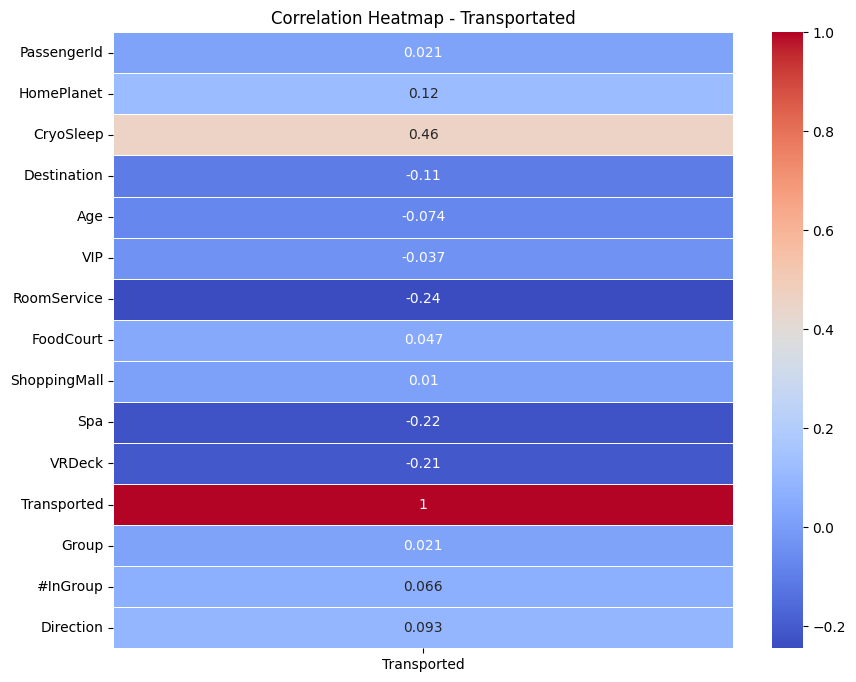

In [20]:
# Heat map to identify what variables are correlated to transportation. 
corr_matrix = train_space_titanic.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['Transported']], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Transportated')

plt.show()

# 4.0 - Training model

In [21]:
X = train_space_titanic.drop(columns=['Transported'])
y = train_space_titanic['Transported']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_dev_pred = model.predict(X_dev)

print(f'Training Accuracy: {accuracy_score(y_train, y_train_pred):.2%}')
print(f'Development Accuracy: {accuracy_score(y_dev, y_dev_pred):.2%}')
print(classification_report(y_dev, y_dev_pred))


Training Accuracy: 100.00%
Development Accuracy: 77.86%
              precision    recall  f1-score   support

       False       0.77      0.78      0.78       861
        True       0.78      0.77      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [29]:
print(X.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group',
       '#InGroup', 'Direction'],
      dtype='object')


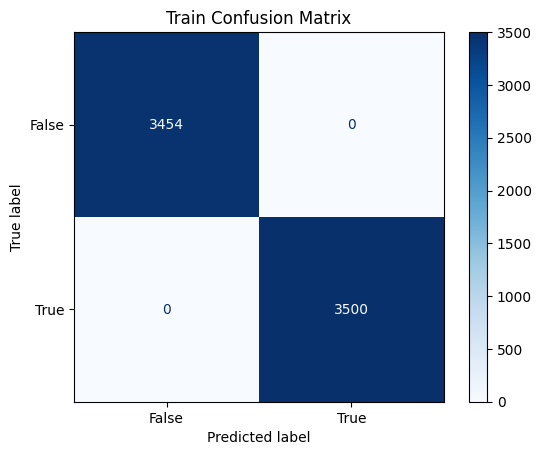

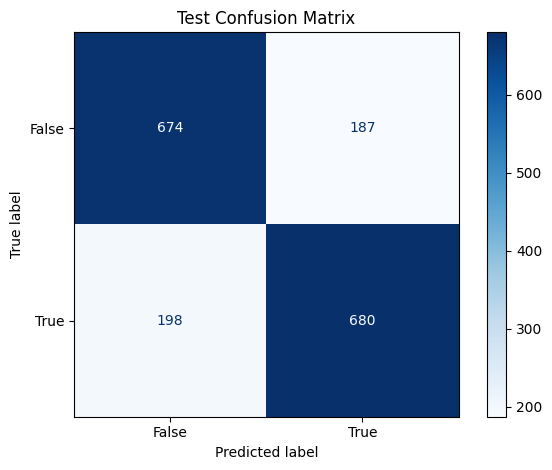

In [23]:
cm = confusion_matrix(y_train, y_train_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Train Confusion Matrix')

cm = confusion_matrix(y_dev, y_dev_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Test Confusion Matrix')
plt.tight_layout()

Predicts False negatives 293 times where predicts that a person is not transported when they actually are. Hyperparameter tuning used to try and improve the accuaracy of the model. 


In [ ]:
random_f_model = RandomForestClassifier(random_state=42)

parameter = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [1,5,10,20,50,100],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': [1,2,3,6,10]
}

grid_search = GridSearchCV(estimator=random_f_model, param_grid=parameter, cv = 3, 
                           n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [24]:
#From hyperparametertunig
model_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

X = train_space_titanic.drop(columns=['Transported'])
y = train_space_titanic['Transported']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.2, random_state = 42)

model_tuned.fit(X_train, y_train)

y_train_pred = model_tuned.predict(X_train)
y_dev_pred = model_tuned.predict(X_dev)

dump(model_tuned, 'Titanic_randomforest_model.joblib')

print(f'HyperTraining Accuracy: {accuracy_score(y_train, y_train_pred):.2%}')
print(f'HyperDevelopment Accuracy: {accuracy_score(y_dev, y_dev_pred):.2%}')


HyperTraining Accuracy: 87.19%
HyperDevelopment Accuracy: 78.61%


# 5.0 - Test data

In [25]:
missing_values = test_titanic.isnull().any(axis=1).sum()
print(f'Total number of rows with missing values: {missing_values}')

threshold = 2

multi_missing_values = test_titanic.isnull().sum(axis=1)
rows_missing_variables = test_titanic[multi_missing_values >= threshold]
proportion = (missing_values / 8693) * 100
print(f'Proportion of rows missing data: {proportion:.2f}%')
print(f'Rows missing more than one variable: {len(rows_missing_variables)}')

Total number of rows with missing values: 996
Proportion of rows missing data: 11.46%
Rows missing more than one variable: 117


In [ ]:
# Replace null values for age. Replacing with median removes impact of outliers in age, that would impact the mean.
test_titanic['Age'] = test_titanic['Age'].fillna(test_titanic['Age'].median())
# Drop name from the dataset. 
test_titanic.drop(['Name'], axis=1, inplace=True)

In [ ]:
# Identify frequency of Home and destination planets.
HPfrequency_counts = test_titanic['HomePlanet'].value_counts(normalize=True)
DPfrequency_counts = test_titanic['Destination'].value_counts(normalize=True)
print(HPfrequency_counts)
print(DPfrequency_counts)

In [28]:
test_titanic.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [ ]:
# Change missing values in dataframe to the mode value.
test_titanic['HomePlanet'] = test_titanic['HomePlanet'].fillna('Earth').replace('', 'Earth')
test_titanic['Destination'] = test_titanic['Destination'].fillna('TRAPPIST-1e').replace('', 'TRAPPIST-1e')

# Add NaN values in VIP and CryoSleep with Mode of the dataset for those variables. 
test_titanic['VIP'] = test_titanic['VIP'].replace('', np.nan).fillna(test_titanic['VIP'].mode()[0])
test_titanic['CryoSleep'] = test_titanic['CryoSleep'].replace('', np.nan).fillna(test_titanic['CryoSleep'].mode()[0])

# Passenger ID contains information on the number of people in a particular family group. Extract group size from the PassengerID variable. 
test_titanic[['Group', '#InGroup']] = test_titanic['PassengerId'].str.split('_', expand=True)

# Identify from cabin number whether passenger was on port of starboard of the ship
test_titanic['Direction'] = test_titanic['Cabin'].str.split('/').str[-1]
test_titanic = test_titanic.drop(columns=['Cabin'])

#Encoding
le = LabelEncoder()

for col in ['HomePlanet', 'CryoSleep', 'Destination', 'Direction']:
    test_titanic[col] = le.fit_transform(test_titanic[col])


In [ ]:
# Run model on the test data. 
model = joblib.load('Titanic_randomforest_model.joblib')

predictions = model.predict(test_titanic) # Produces encoded values.
bool_predictions = predictions.astype(bool) # Transforms 

test_titanic['Transported'] = bool_predictions

# Data to CSV
results_titanic = test_titanic[['PassengerId', 'Transported']]

results_titanic.to_csv('results_space_titanic.csv', index=False)
